#  Airbnb Tutorial:  Listing prices in San Francisco
### QIYANG HE  



This tutorial will help you to go over basic web scraping techniques and the necessary interaction with Airbnb api. Besides, we will convey data cleaning ideas that help us to regulate the dataset from raw format. Finally, we will use gmaps package to do data visualization as well as exploration data analysis.

The major part of this tutorial will be
- [Intuition](#Intuition): What we can figure out through this tutorial, why we choose these techniques.
- [Library installation](#Library-installation): Establish necessary environment for our tutorial.
- [Airbnb api exploration](#Airbnb-api-exploration): Figure out how to make interactions with Airbnb api.
- [Web Scraping from Airbnb](#Web-Scraping-from-Airbnb): Integrate the whole scraping idea and form a whole dataset
- [Visualization with gmaps](#Visualization-with-gmaps): Use gmaps to visualize san francisco listing distribution
- [Visualization with geojson layer](#Visualization-with-geojson-layer): Use san francisco districts geojson file to achieve average price visualization.
- [Exploration data analysis with price](#Exploration-data-analysis-with-price): Use color features indicating district level average price
- [Possible future work](#Possible-future-work): The possible future work that can be done from created dataset/ used techniques.
- [References](#References): The url of api and package documentations

## Intuition


Usually, San Francisco will be a great place for people to take vacations and visit friends during summer. Moreover, many of us may obtain internship opportunities in San Francisco Bay area. For some reason, you may want to find reliable housing for short lease term, no matter for just couple of days if you are planning for a vacation, or one to two months if you are for internship opportunities. Under such circumstances, Airbnb will be a good choice for you to find desired housing.

In this tutorial, we will limit our discussion specifically within San Francisco area. First of all, We will trying to obtain valid listing data from Airbnb websites and form useful dataset. We choose Airbnb api to send requests instead of scraping websites directly because we want to get more formatted results from our query (for instance, json formatted response).  

Furthermore, we will do some visualization and exploration data analysis. You will get basic idea of the distribution of San Francisco Airbnb listing as well as the average price report. It's not hard to find out the underlying relations between the listing prices and their locations. In order to achieve this, we introduce gmaps package that could plotting geodata by adding layers onto the google maps. This could also be a good example of using gmaps packages to achieve geodata plotting.

## Library installation

First of all, we need to initialize packages and libraries that we will be using for this tutorial.

In [2]:
import json
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import timeit #used to track computation time
import copy  #used for deepcopy
import math
from matplotlib.colors import to_hex
from IPython.display import Image  

Apart from that, we also need to initialize gmaps environment. you can achieve this by running the following from the commandline. First of all, you need to enable ipywidgets widgets extensions:

    $  jupyter nbextension enable --py --sys-prefix widgetsnbextension
    
Then install gmaps package by calling pip:

    $  pip install gmaps
    
Finally, call the following to let jupyter load the extensions:

    $  jupyter nbextension enable --py --sys-prefix gmaps

Of course, you could also uncomment the following block and run it to achieve the installation. If you cannot see the gmap plotting after setting up the environment, hopefully you need to restart the jupyter notebook.

In [40]:
# ! jupyter nbextension enable --py --sys-prefix widgetsnbextension
# ! pip install gmaps
# ! jupyter nbextension enable --py --sys-prefix gmaps

In [41]:
import gmaps

## Airbnb api exploration

If you open your browser(let's assume you are using chrome) and searching airbnb by typing any location into the search bar and click search, you could find out that the website actually interact with it's backend server by calling its api. The link format will be something like that: 

https://api.airbnb.com/v2/search_results?client_id=3092nxybyb0otqw18e8nh5nty&locale=en-US&currency=USD&_format=for_search_results_with_minimal_pricing&_limit=10&_offset=0&fetch_facets=true&guests=1&ib=false&ib_add_photo_flow=true&location=Lake%20Tahoe%2C%20CA%2C%20US&min_bathrooms=0&min_bedrooms=0&min_beds=1&min_num_pic_urls=10&price_max=210&price_min=40&sort=1&user_lat=37.3398634&user_lng=-122.0455164

You can figure it out by right clicking 'inspect' from airbnb website, then click network tab and then search the website. You will notice that a json formatted response will be received which just contain all the listing info we need for a single home tab page ! The basic api search url for home tab could be https://api.airbnb.com/v2/search_results

If we form request like below, we will get a json response containing 20 listing info (we set the search limit to be 20 for each search request). Here I use the api key(in dictionary shows 'client_id') listed on Airbnb api documentation example, you can simply register for a new one if you need a private api key. From the json response we can easily obtain the parameters we want(e.g. listing id).

Another interesting point is that in our example, I specified 'check in' and 'check out' params. However, this is not necessary because Airbnb provide search option that can be based on any time period, which means we can even develop a search without specifying the check-in and check-out dates.

In [42]:
params = {
    'client_id':'3092nxybyb0otqw18e8nh5nty',
    'locale': 'en',
    'checkin': '2018-05-13',
    'checkout': '2018-05-15',
    'location': "Fisherman's Wharft, San Francisco, CA, United States",
    'guests': 1,
    '_limit': 20,
    '_offset': 0,
}
raw_url = 'https://api.airbnb.com/v2/search_results'
response = requests.get(raw_url, params = params)
print(response.url)

https://api.airbnb.com/v2/search_results?client_id=3092nxybyb0otqw18e8nh5nty&locale=en&checkin=2018-05-13&checkout=2018-05-15&location=Fisherman%27s+Wharft%2C+San+Francisco%2C+CA%2C+United+States&guests=1&_limit=20&_offset=0


In [67]:
result = response.json()
print(response)
print(len(result['search_results']))
room_id_0 = result['search_results'][0]['listing']['id']
print(room_id_0)
# print(result)

<Response [200]>
7
8904937


From above json response we can find out that this response contains parts of unnecessary information that we actually does not need. Besides, we may need more data about a particular listing, such as it's summary information, number of amenities, etc. In order to achieve this, we need to form a new listing search request, which basically return a json response that contains information which can be used to form an individual listing web page. We can form a request just like what we did before. We can parse listing information from json response, for instance, the name of this listing displayed on it's main page.

In [52]:
params_listing = {
    'client_id':'3092nxybyb0otqw18e8nh5nty',
    '_format': 'v1_legacy_for_p3',   # mysterious token for listing search request
}
raw_listing_id_url = 'https://api.airbnb.com/v2/listings/'+str(room_id_0)     #basic search request url
response_listing = requests.get(raw_listing_id_url, params = params_listing)
print(response_listing.url)

https://api.airbnb.com/v2/listings/8904937?client_id=3092nxybyb0otqw18e8nh5nty&_format=v1_legacy_for_p3


In [54]:
result_listing = response_listing.json()
print(response_listing)
print(response.status_code == 200)
print(result_listing['listing']['name'])  #print listing name
# print(result_listing)

<Response [200]>
True
Big Room in great location, queen bed and futon


## Web Scraping from Airbnb

When comnbining these two scraping techniques together, we can actually form a whole dataset containing hopefully all the housing info in San Francisco Area. The basic idea is to specify the http request params first, then parse the home tab from response, and then we can get detailed listing info by sending another http request indicating specified listing id. When all of the info for one listing is fetched, we simply append it's data to a dictionary and finally we will form a dataset from this dictionary.

Airbnb has a sophisticated backend database system, from which we cannot get full listing data at one time (more precisely, you will only be provided approximately 300 listing search results). Moreover, the database is periodically updated based on new housing and other information update. Here I will output the dataset at my timestamp. If you rerun my code you may get a slightly different dataset from my version, but you get the idea.

In order to get a more complete dataset, we query Airbnb websites based on district area in San Francisco. From https://www.airbnb.com/locations/san-francisco/neighborhoods we create a list including specific neighborhoods/district area, which we could be used to narrow down each of our search request and finally get a more comprehensive dataset:

In [76]:
def parse_districts(url):
    '''
    parse district information from the website
    return:  a list of district names in San Francisco
    '''
    def clean_str(area):
        if area[0] == ' ':
            area = area[1:len(area)]
        elif area[-1] == ' ':
            area = area[0:-1]
        return area
    district = str(requests.get(url).content)
    root = BeautifulSoup(district,'html.parser')
    lista = [ele.find('h2').text.replace('\\','') for ele in root.find_all("div",class_="center panel-padding")]
    area_sf = []
    for ele in lista:
        if '/' in ele:
            area_sf.extend([clean_str(area) for area in ele.split('/')])
        else:
            area_sf.append(clean_str(ele))
    return area_sf

In [77]:
# get San Francisco district lists
url='https://www.airbnb.com/locations/san-francisco/neighborhoods'
sf_area = parse_districts(url)
print(len(sf_area))
print(sf_area)

40
['Alamo Square', 'Bayview', 'Bernal Heights', 'Chinatown', 'Civic Center', 'Cole Valley', 'Cow Hollow', 'Dogpatch', 'Downtown', 'Duboce Triangle', 'Excelsior', 'Financial District', "Fisherman's Wharf", 'Glen Park', 'Haight-Ashbury', 'Hayes Valley', 'Inner Sunset', 'Lower Haight', 'Marina', 'Mission District', 'Mission Terrace', 'Nob Hill', 'Noe Valley', 'North Beach', 'Outer Sunset', 'Pacific Heights', 'Portola', 'Potrero Hill', 'Presidio Heights', 'Richmond District', 'Russian Hill', 'SoMa', 'South Beach', 'Telegraph Hill', 'Tenderloin', 'The Castro', 'Twin Peaks', 'Visitacion Valley', 'Western Addition', 'NOPA']


Now it comes to real scraping time! We need to combine these three parts (searching based on each district name, scraping listing home tabs, scraping individual listing information based on listing id). We will construct a class to do all the scraping work at one time.

When we are doing the scraping, we actually find that there exists some overlaps between query results for different (more precisely, nearby) districts. We need to explicitly exclude those records from our final dataset. Moreover, the Airbnb will assign each housing its own neighborhood which may be slightly different from our version. It's good to use this part of info to identify our listings considering the overlaps between the query does exist.

We also notice that some requests will receive 503 error from Airbnb server which is just the website issues. If such situation happens, we simply resend the request to the server until we receive response with the status code 200. Fortunately this kind of error happens not very often, but we do need to handle it. 

In [78]:
class Airbnb_df:
    
    def __init__(self, sub_location, ck_in = None, ck_out = None, location='San Francisco, CA, United States', 
                 guests=1, client_id='3092nxybyb0otqw18e8nh5nty'):
        '''
        initialize class, create dictionary for storing dataframe entries, create home tab search params module,
        specify other necessary params for searching
        '''
        self.dict_data = {
            'district':[], #listing district location
            'id':[], #listing room id
            'name':[],
            'price':[], #listing price, specifically 'nighly price'
            'lat':[],
            'lng':[],
            'property_type':[],
            'is_new_listing':[],
        
            'pic_count':[],
            'review_count':[],
            'total_rating':[],
            # below are the data fetched from individial listing page
            'review_rate_accu':[],
            'review_rate_ckin':[],
            'review_rate_clean':[],
            'review_rate_communication':[],
            'review_rate_location':[],
            'review_rate_value':[],
        
            'amenities_count':[],
            'description_len':[],
            'rules_len':[],
            'host_verified':[],  #primary_host section
            'host_is_superhost':[],  
        }
        self.client_id = client_id
        self.params_home_tab = {
            'client_id': self.client_id,
            'locale': 'en',
            'location': ', '+location, # append district later
            'guests': guests,
            '_limit': 20,
            '_offset': 0, #offset should be 20 per page
        }
        if ck_in != None:
            self.params_home_tab['checkin'] = ck_in
        if ck_out != None:
            self.params_home_tab['checkout'] = ck_out
        self.raw_home_tab = 'https://api.airbnb.com/v2/search_results'
        self.raw_listing_tab = 'https://api.airbnb.com/v2/listings/'
        self.districts = sub_location
        return 
    
    def scrap_listing(self, room_id):
        '''
        parse response for individual listing page, append data to the dictionary
        return true if success, false if error
        '''
        params_listing = {
            'client_id':self.client_id,
            '_format': 'v1_legacy_for_p3',
        }
        raw_listing_id_url = self.raw_listing_tab+str(room_id)
        response_listing = requests.get(raw_listing_id_url, params = params_listing)
        if response_listing.status_code == 400:
            return False
        result_l = response_listing.json()
        listing = result_l['listing']
        self.dict_data['review_rate_accu'].append(listing['review_rating_accuracy'])
        self.dict_data['review_rate_ckin'].append(listing['review_rating_checkin'])
        self.dict_data['review_rate_clean'].append(listing['review_rating_cleanliness'])
        self.dict_data['review_rate_communication'].append(listing['review_rating_communication'])
        self.dict_data['review_rate_location'].append(listing['review_rating_location'])
        self.dict_data['review_rate_value'].append(listing['review_rating_value'])
        self.dict_data['amenities_count'].append(len(listing['amenities']))
        self.dict_data['description_len'].append(len(listing['description']))
        self.dict_data['rules_len'].append(len(listing['house_rules']))
        self.dict_data['host_verified'].append(1 if listing['primary_host']['identity_verified']=='true' else 0)
        self.dict_data['host_is_superhost'].append(1 if listing['primary_host']['is_superhost']=='true' else 0)
        return True
    
    def scrap_hometab(self, district):
        '''
        parse response for listing hometab, append data to the dictionary
        return nothing
        '''
        params_ht = copy.deepcopy(self.params_home_tab)
        params_ht['location'] = district+params_ht['location']
        incr = params_ht['_limit']
        scrap_success = True
        while scrap_success:
            response = requests.get(self.raw_home_tab, params = params_ht)
            if response.status_code == 400:
                scrap_success = False
            elif response.status_code == 503:
                continue
            else:
                result = response.json()
                if len(result['search_results']) == 0:
                    scrap_success = False
                for i in result['search_results']:
                    if i['listing']['id'] in self.dict_data['id']: # skip dumplicated records
                        continue
                    # if valid, append data to the dictionary
                    listing = i['listing']
                    self.dict_data['district'].append(listing['neighborhood'])
                    self.dict_data['id'].append(listing['id'])
                    self.dict_data['name'].append(listing['name'])
                    self.dict_data['price'].append(i['pricing_quote']['nightly_price'])
                    self.dict_data['lat'].append(listing['lat'])
                    self.dict_data['lng'].append(listing['lng'])
                    self.dict_data['property_type'].append(listing['property_type'])
                    self.dict_data['is_new_listing'].append( 1 if listing['is_new_listing'] == 'true' else 0)
                    self.dict_data['pic_count'].append(listing['picture_count'])
                    self.dict_data['review_count'].append(listing['reviews_count'])
                    self.dict_data['total_rating'].append(listing['star_rating'])
                    self.scrap_listing(listing['id'])
                params_ht['_offset'] += incr
#                 print("location " + district+" with offset "+str(params_ht['_offset'])+" scrap finished")
        return
    
    def scrap_total(self):
        '''
        scraping wrapper, execute scraping based on district names
        return final dataframe
        '''
        for district in self.districts:
            start = timeit.default_timer()
            self.scrap_hometab(district)
            end = timeit.default_timer()
            print("scraping "+district+" finished in "+str(end-start)+" seconds")
        return pd.DataFrame(self.dict_data)

In [79]:
test = Airbnb_df(sf_area)

In [80]:
df = test.scrap_total()

scraping Alamo Square finished in 34.208446654025465 seconds
scraping Bayview finished in 85.8096459240187 seconds
scraping Bernal Heights finished in 223.899807902053 seconds
scraping Chinatown finished in 23.867139677982777 seconds
scraping Civic Center finished in 42.4232016740134 seconds
scraping Cole Valley finished in 43.81060984299984 seconds
scraping Cow Hollow finished in 52.408784936065786 seconds
scraping Dogpatch finished in 15.886543489992619 seconds
scraping Downtown finished in 22.989693998009898 seconds
scraping Duboce Triangle finished in 60.24476809997577 seconds
scraping Excelsior finished in 68.23911833099555 seconds
scraping Financial District finished in 1.4960505239432678 seconds
scraping Fisherman's Wharf finished in 19.18378959200345 seconds
scraping Glen Park finished in 57.056292811990716 seconds
scraping Haight-Ashbury finished in 95.57724958600011 seconds
scraping Hayes Valley finished in 46.91641985299066 seconds
scraping Inner Sunset finished in 94.588305

Above are the results I got when I did my scraping. As you can see, some of the district listings take lots of time to fetch. The major reason is that within each home tab, we have to fetch the detailed listing info for each of the listing and some of them might take more than 1 second. If you are not going to use that part of the data, you could simply neglect the 'scrap_listing' call within 'scrap_total' call which will speed up the total scraping and save you a lot of time. Let's take a glimpse of our dataset.

In [82]:
df.head()

,amenities_count,description_len,district,host_is_superhost,host_verified,id,is_new_listing,lat,lng,name,...,property_type,review_count,review_rate_accu,review_rate_ckin,review_rate_clean,review_rate_communication,review_rate_location,review_rate_value,rules_len,total_rating
0,17,2440,Alamo Square,0,0,25463,0,37.777289,-122.434211,Modern Zen in the Lower Haight,...,Townhouse,344,10.0,10.0,10.0,10.0,10.0,10.0,699,5.0
1,21,1713,Alamo Square,0,0,808919,0,37.776998,-122.436807,Cozy Victorian in Alamo Square Area,...,Apartment,42,10.0,10.0,10.0,10.0,10.0,10.0,0,5.0
2,14,3551,Alamo Square,0,0,4718531,0,37.778362,-122.431235,Beautiful Little Room in Victorian,...,House,234,10.0,10.0,10.0,10.0,10.0,10.0,46,5.0
3,38,3324,Alamo Square,0,0,20522264,0,37.777533,-122.434440,The McAllister Victorian Five,...,House,24,9.0,10.0,9.0,10.0,10.0,9.0,0,5.0
4,15,1304,Alamo Square,0,0,19995782,0,37.774834,-122.434064,Cozy Flat Near Alamo Square,...,Apartment,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


Because the listing info may be updated/changed frequently, I will save the dataset for the future use. If you decide to create a most updated housing dataset from Airbnb, you can simply rerun my code to fetch the related websites.

Below are the codes to output/load the dataset.

In [83]:
#output dataset
df.to_csv('airbnb_full.csv', encoding='utf-8',index = False)

In [2]:
#load dataset
df = pd.read_csv('airbnb_full.csv')

## Visualization with gmaps

In order to give a good visualization of our dataset, here we choose gmaps package to construct a heated map indicating the listing distribution of our dataset. By doing the following you can get approximately the same geoplot as I got.

To achieve this, we first need to register a google api key from https://developers.google.com/maps/documentation/geocoding/get-api-key

The basic workflow is that you configure the google api key, then set params for your gmap instance, and then add layers to the plot. you can set default center point, default zoom level on the map, just like what I did. You will find more interesting params that you may need to set up your own map if you go over the gmaps documentation.

Considering the jupyter may not preload the widgets, I will preload the plot that I got to help you get better ideas when you are going through my workflow.

In [68]:
# read my own mysterious google api key
def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')
apiKey = read_api_key('api_key.txt')

In [59]:
#config gmap
gmaps.configure(api_key=apiKey)
sf_coordinates = (37.7749,-122.4194)
figure_layout = {'width': '800px','height':'620px', 'margin': '0 auto 0 auto'}

In [60]:
fig = gmaps.figure(layout = figure_layout, zoom_level = 12.2, center = sf_coordinates)
location = np.array([(df['lat'][i],df['lng'][i]) for i in range(len(df))])
fig.add_layer(gmaps.heatmap_layer(location))
fig

A Jupyter Widget

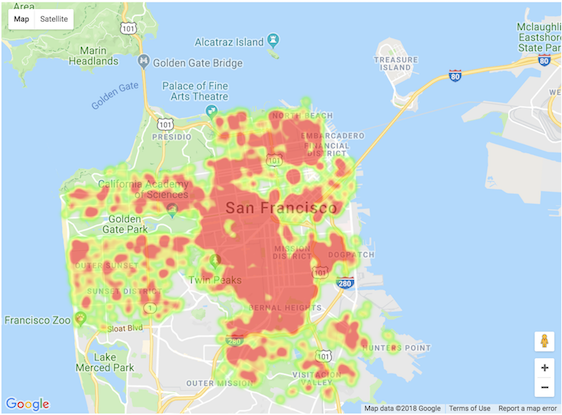

In [4]:
Image(filename='tutorial_map/heat.png')

We add a heated map layer containing all the listing records from the dataset. From the plot we find out that the majority of the listings are located in the middle areas of the city, such as Mission district. Not Surprisingly, the places near the seaside are always heated area for listings. 

There are some places that are nearly blank for listing distribution, such as Golden Gate Park (of course, it's not common to own a property inside a public park) and Presidio (few people will be willing to live nearby a national cemetery), all of which seems reasonable.

## Visualization with geojson layer

If we want to know the distribution of the listings at district level, we need to introduce geojson layer onto our map. As a result, we need to get a geojson file that includes all the latitude and longitude information ofdistricts in San Francisco. We fetched one from github: https://github.com/blackmad/neighborhoods/blob/master/gn-san-francisco.geojson. 

The geojson file includes lots of information we need, which will help us to achieve a better visualization.

In [61]:
with open("sf_geo_n2.json") as f:
    geometry = json.load(f)

fig_json = gmaps.figure(layout = figure_layout, zoom_level = 12.2, center = sf_coordinates)
location = np.array([(df['lat'][i],df['lng'][i]) for i in range(len(df))]) #retrieve listing locations
geojson_layer = gmaps.geojson_layer(geometry,fill_color = (0, 0, 0, 0.5))
fig_json.add_layer(geojson_layer)
fig_json.add_layer(gmaps.heatmap_layer(location))

fig_json

A Jupyter Widget

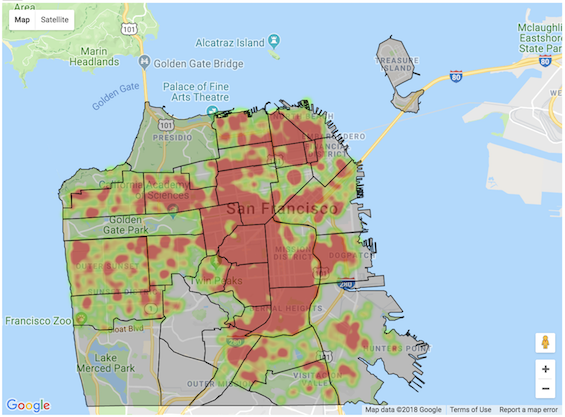

In [5]:
Image(filename='tutorial_map/heat_grid.png')

From then on, we are clearly informed about the listing distribution within each area. But if we need to do exploration data analysis, let's say, about the listing prices, we need to introduce more params to our map.

## Exploration data analysis with price

If we want to display the average price for each district and get a clean visualization on the map, a good approach is to assign each area with different colors indicating different price level. 

In order to achieve this, we map the districts from our dataset with the districts listed in geojson file, then calculate the average price for each districts, assign color levels to them by passing through an array of color hex values. The dark areas indicating a high listing price, and the shallow areas indicating a low listing price.

In [15]:
#get unique district names from geojson file
json_sf_area = [ele['properties']['name'] for ele in geometry['features']]
print(len(json_sf_area))
print(json_sf_area)

37
['Seacliff', 'Marina', 'Pacific Heights', 'Nob Hill', 'Presidio Heights', 'Downtown/Civic Center', 'Excelsior', 'Bernal Heights', 'Western Addition', 'Chinatown', 'North Beach', 'Haight Ashbury', 'Outer Mission', 'Crocker Amazon', 'West of Twin Peaks', 'South of Market', 'Potrero Hill', 'Inner Richmond', 'Bayview', 'Noe Valley', 'Inner Sunset', 'Diamond Heights', 'Lakeshore', 'Russian Hill', 'Treasure Island/YBI', 'Twin Peaks', 'Outer Richmond', 'Visitacion Valley', 'Golden Gate Park', 'Parkside', 'Financial District', 'Ocean View', 'Mission', 'Presidio', 'Castro/Upper Market', 'Outer Sunset', 'Glen Park']


In [16]:
#get unique district names from our dataset
unique_sf = df['district'].unique()
print(len(unique_sf))
print(unique_sf)

45
['Alamo Square' 'Bayview' 'Bernal Heights' 'Chinatown' 'SoMa'
 'Civic Center' 'Hayes Valley' 'Western Addition/NOPA' 'Tenderloin'
 'Cole Valley' 'Haight-Ashbury' 'Cow Hollow' 'Pacific Heights' 'Marina'
 'Dogpatch' 'Financial District' 'Duboce Triangle' 'Excelsior'
 "Fisherman's Wharf" 'Glen Park' 'Lower Haight' 'Mission District'
 'Inner Sunset' 'Parkside' 'West Portal' 'Mission Terrace' 'Sunnyside'
 'Crocker Amazon' 'Nob Hill' 'Noe Valley' 'Diamond Heights'
 'Telegraph Hill' 'Russian Hill' 'North Beach' 'Outer Sunset' 'Portola'
 'Potrero Hill' 'Presidio Heights' 'Richmond District' 'Sea Cliff'
 'South Beach' 'The Castro' 'Twin Peaks' 'Visitacion Valley' 'Japantown']


In [17]:
#map variables, creating dataframe
district_mapping = {
    'json_district': json_sf_area,
    'df_area':[['Sea Cliff'],['Marina','Cow Hollow'],['Pacific Heights'],['Nob Hill'],['Presidio Heights'],
               ['Tenderloin','Union Square','Downtown'],['Excelsior','Portola'],['Bernal Heights'],
               ['Western Addition/NOPA','Hayes Valley','Japantown','Alamo Square','Lower Haight'],
               ['Chinatown'],['North Beach',"Fisherman's Wharf",'Telegraph Hill'],['Haight-Ashbury','Cole Valley'],
               ['Mission Terrace','Sunnyside'],['Crocker Amazon'],['West Portal'],['SoMa','South Beach'],
               ['Potrero Hill','Dogpatch'],['Richmond District'],['Bayview'],['Noe Valley'],['Inner Sunset'],
               ['Diamond Heights'],['Lakeshore'],['Russian Hill'],[],['Twin Peaks'],['Richmond District'],
               ['Visitacion Valley'],[],['Parkside'],['Financial District'],['Ocean View'],['Mission District'],
               ['Presidio'],['The Castro','Duboce Triangle'],['Outer Sunset'],['Glen Park']],
    'ave_price': np.zeros(len(json_sf_area)),
    'level':np.zeros(len(json_sf_area)),
}
df_price = pd.DataFrame(district_mapping)

The way we assign color is that we assign the most expensive area with the darkest color, in rgb which is (255,255,255), then we decrease the y and z value for each level until they reach zero. After that we start to decrease x value, while leaving y and z to be 0. We can form a red-color based color array through this method. You can simply change the rule to render your desired color arrays, but make sure the final color arrays are in hex value.

In [18]:
#create color tuple
def color_list(level):
    x = 255.0
    y = 255.0
    z = 255.0
    q = 0.5
    dec = 15
    c_level = []
    dec_x = False
    for i in range(len(level)):
        if not dec_x:
            c_level.append((x/255,(y-i*dec)/255,(z-i*dec)/255))
        else:
            c_level.append(((x-dec)/255,0,0))
            x -= dec
        dec_x = True if y-i*dec<=dec else False
    hex_level = [to_hex(x) for x in c_level]
    return (hex_level,c_level)

In [63]:
# create dataset for price display
def create_price_dataset(params, df):
    '''
    describe what need to deliver 
    '''
    ave_price = [np.mean(df[df['district'].isin(ele)]['price']) for ele in params['df_area']]
    ave_price = [0 if math.isnan(x) else x for x in ave_price ]
    params['ave_price'] = ave_price.copy()
    key = list(set(ave_price))
    key.sort()
    level = np.arange(len(key))
    #create color tuple
    hex_color,rgb_color = color_list(level)
    c_level = dict(zip(key,hex_color))
    level = [ c_level[ele] for ele in params['ave_price']]
    params['level'] = level
    ret_df = pd.DataFrame(params)
    return ret_df

In [64]:
df_price = create_price_dataset(district_mapping, df)

In [21]:
df_price

,ave_price,df_area,json_district,level
0,304.250000,[Sea Cliff],Seacliff,#5a0000
1,346.430556,"[Marina, Cow Hollow]",Marina,#3c0000
2,329.614583,[Pacific Heights],Pacific Heights,#4b0000
3,285.276923,[Nob Hill],Nob Hill,#780000
4,486.533333,[Presidio Heights],Presidio Heights,#1e0000
5,82.133333,"[Tenderloin, Union Square, Downtown]",Downtown/Civic Center,#fff0f0
6,127.905263,"[Excelsior, Portola]",Excelsior,#ffb4b4
7,177.130769,[Bernal Heights],Bernal Heights,#ff5a5a
8,252.237389,"[Western Addition/NOPA, Hayes Valley, Japantow...",Western Addition,#960000
9,286.838710,[Chinatown],Chinatown,#690000


Next, we will add this geojson layer to our map. The basic idea is the same as we did before, just create a map instance first, then add geojson layer onto it.

In [65]:
with open("sf_geo_n2.json") as f:
    geometry = json.load(f)

fig_price = gmaps.figure(layout = figure_layout, zoom_level = 12.2, center = sf_coordinates)
geojson_layer = gmaps.geojson_layer(geometry,fill_color = list(df_price['level']),fill_opacity=0.7)
fig_price.add_layer(geojson_layer)

fig_price

A Jupyter Widget

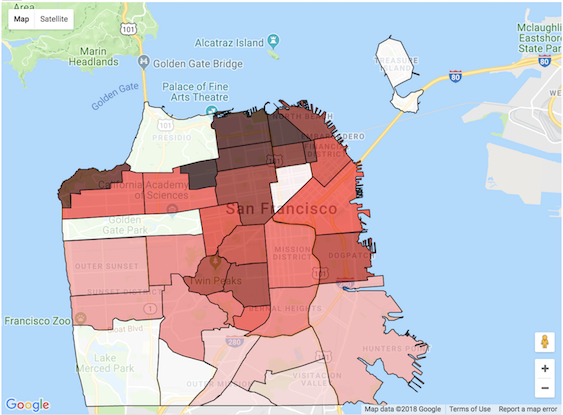

In [6]:
Image(filename='tutorial_map/color_grid.png')

An interesting pattern detected from map is that the north part of the city is more expensive than the south part, the west part of the city is generally cheaper than the east part. Because there are many touristing places near the north beach (e.g. Fisherman's Whalf, Golden Gate Bridge), the listings nearby will be much expensive than those at other places.

This plot actually cannot fully display the information we need. We do know the area price level from the plot, but we do not know the corresponding district names, the exact average prices as well as the listing numbers. We need to add another marker layer which will presenting more information. 

In [24]:
## create marker layers
def marker_visual(geojson, df_price, df):
    '''
    return tuple of three lists(district geolocation list, average price list, information list)
    '''
    location = []
    price_label = []
    info_box = []
    for line in geojson['features']:
        district_name = line['properties']['name']
        location.append((line['properties']['lat'],line['properties']['lng']))
        ave_price = int(list(df_price[df_price['json_district'] == district_name]['ave_price'])[0])
        price_label.append("$"+str(ave_price) if ave_price != 0 else 'None' )
        listing_num = len(df[df['district'].isin(list(df_price[df_price['json_district']==district_name]['df_area'])[0])])
        info_box.append('Area: '+district_name+"           Total listings: "+str(listing_num))
    return (location, price_label, info_box)

The reason that we choose markers to represent the information is that it can display data in two-level manners, which is the label combined with a click-on display of the data. The label in our case is just the average price for each district. The information box will actually presenting specific area as well as the total listings inside this area. By adding this marker layer onto our gmap, a more illustrative data visualization will be provided for our data exploration analysis.

In [66]:
fig_marker = gmaps.figure(layout = figure_layout, zoom_level = 12.2, center = sf_coordinates)
geojson_layer = gmaps.geojson_layer(geometry,fill_color = list(df_price['level']),fill_opacity=0.7)
fig_marker.add_layer(geojson_layer)
geo_turple = marker_visual(geometry, df_price, df)
markers = gmaps.marker_layer(geo_turple[0],info_box_content = geo_turple[2],label = geo_turple[1])
fig_marker.add_layer(markers)

fig_marker

A Jupyter Widget

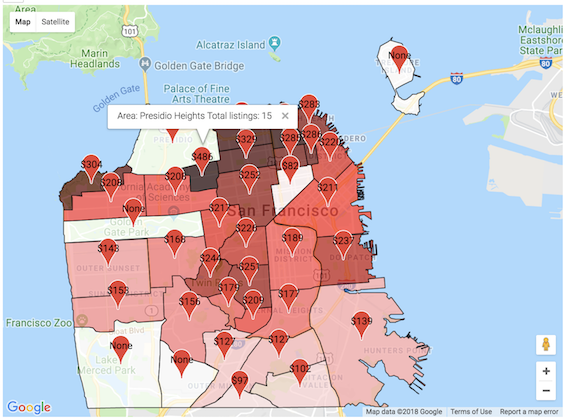

In [7]:
Image(filename='tutorial_map/grid_marker.png')

## Possible future work

In this tutorial we only use part of our dataset fetched from Airbnb. However this dataset also contains other interesting features, such as listing description length, ratings, amenity numbers, so on and so forth. You could make regression analysis based on my data, you could also train models and make predictions on price based on given listing information. There are many things that you can do with this dataset.

## References

 - geojson file   https://github.com/blackmad/neighborhoods/blob/master/gn-san-francisco.geojson
 - gmaps documentation   http://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html#base-maps
 - airnbnb api       http://airbnbapi.com/
 - googlemap api     https://developers.google.com/maps/documentation/geocoding/get-api-key